<a href="https://colab.research.google.com/github/NREL/NREL-Beam-Characterization/blob/main/SimulatedNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cv2
from sklearn import mixture 
import scipy.stats as stats 
%matplotlib inline
import skimage 
import skimage.draw

In [ ]:
def pl_ellipse(x0, y0, sx, sy, th):
    """Return points to plot an ellipse"""
    t = np.linspace(0,2*np.pi)
    x = sx * np.cos(t)
    y = sy * np.sin(t)
    xrot = x * np.cos(th) - y * np.sin(th) + x0
    yrot = x * np.sin(th) + y * np.cos(th) + y0
    return (xrot, yrot)

(x_ell, y_ell) = pl_ellipse(300, 200, 50, 25, np.deg2rad(30))
#plt.plot(x_ell, y_ell)
#plt.axis('equal')
#plt.grid()

pass

# Simulate a Gaussian Beam

300 200 1000 50 25 0.5235987755982988
400 300 1000 70 30 0.2617993877991494


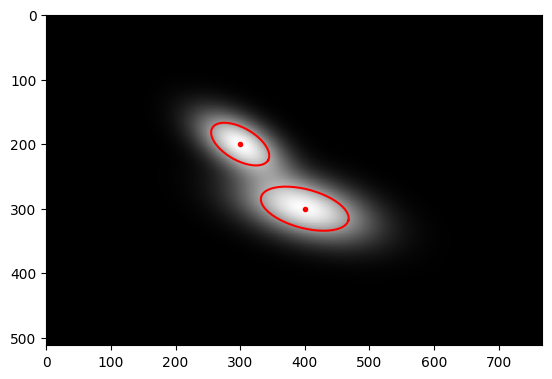

(512, 768)
(131072, 3)


In [ ]:
# Size of image
nx = 768
ny = 512

# Noise
noise = 0

# Positions of Gaussians
x0s = (300,400,)
y0s = (200,300,)
I0s = (1000,1000,) # Peak intensity
sxs = (50,70,)  # Standard deviations and angle
sys = (25,30,)
thetas = (30,15,) # In degrees!

# Make axes
x = np.arange(nx)
y = np.arange(ny)

# Create image with uniform noise
image = noise * np.random.random((ny,nx))

# Add Gaussian peaks to image
for i in range(len(x0s)):
    x0 = x0s[i]
    y0 = y0s[i]
    I0 = I0s[i]
    sx = sxs[i]
    sy = sys[i]
    theta_deg = thetas[i]
    th = np.deg2rad(thetas[i])
    print(x0,y0,I0, sx, sy, th)
    # Get ellipsoid parameters
    a = np.cos(th)**2 / (2 * sx**2) + np.sin(th)**2 / (2 * sy**2)
    b = -0.25 * np.sin(2 * th) * (-1 / sx**2 + 1 / sy**2)
    c = np.sin(th)**2 / (2 * sx**2) + np.cos(th)**2 / (2 * sy**2)
    # Add Gaussian to image
    image += I0 * np.exp(-( \
                           a * (x[None,:]-x0)**2 + \
                           2 * b * (x[None,:]-x0) * (y[:,None]-y0) + \
                           c * (y[:,None]-y0)**2 \
                          ))
    (x_ell, y_ell) = pl_ellipse(x0, y0, sx, sy, np.deg2rad(theta_deg))
    plt.plot(x0, y0, '.', c='red')
    plt.plot(x_ell, y_ell, '-r')



image = np.array(255 * image / np.max(image), dtype=np.uint8)
    
int_image = np.array(image, dtype=np.uint8)
plt.imshow(int_image, interpolation='nearest', cmap='gray')
plt.show()

print(image.shape)
img2 = image.reshape((-1,3))
print(img2.shape)
X = image[:, ::-1] # flip axes for better plotting

In [ ]:
from sklearn.mixture import GaussianMixture as GMM
g = mixture.GaussianMixture(n_components=2, covariance_type= 'full').fit(X)

from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)



AttributeError: ignored

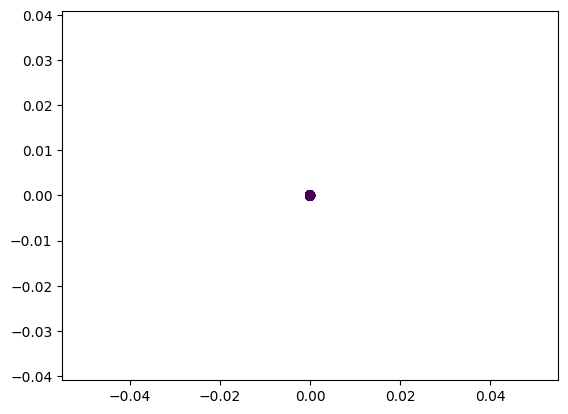

In [ ]:
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X)

In [ ]:
kernel = np.ones((3, 3), np.uint8)
M = cv2.moments(int_image)

x1 = M['m10']/M['m00']
y1 = M['m01']/M['m00']

x2 = M['mu20']/M['m00']
y2 = M['mu02']/M['m00']
xy2 = M['mu11']/M['m00']

print(x1, y1)
print(x2, y2, xy2)
print(np.sqrt(x2), np.sqrt(y2))


In [ ]:
from matplotlib.patches import Ellipse

ell = Ellipse(xy=(x1, y1),
                width=np.sqrt(x2), height=np.sqrt(y2),
                angle=theta_deg, fill=False, ec='black')

fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
ax.imshow(int_image, interpolation='nearest')
ax.plot(x1, y1, '.r')
plt.plot(x_ell, y_ell, '-r')
ax.add_artist(ell)



In [ ]:
from google.colab import drive
drive.mount("/content/drive")
plt.savefig("/content/drive/MyDrive/NREL/GMM1.png")
